# Calculating Magnitudes for a user-provided SED #

This notebook provides an example of calculating the expected AB magnitude in each filter for a user-provided spectral energy distribution (SED) with Rubin Observatory.

Many example SEDs can be found in the `sims_sed_library` (downloadable from NCSA as a [gzipped tar file](https://lsst.ncsa.illinois.edu/sim-data/sed_library/seds_170124.tar.gz)). This file has additional documentation in [confluence](https://confluence.lsstcorp.org/display/SIM/SED+%28Spectral+Energy+Density%29+models+in+the+Catalogs+Simulation+Framework), but includes Kurucz model spectra for main sequence stars, MLT spectra, white dwarf spectra, a range of asteroid spectral types, and various galaxy spectral templates.

This example will use a Kurucz model appropriate for our Sun (`kurucz_sun`) which has been copied into the photometry directory of the [rubin_sim_notebooks](https://github.com/lsst/rubin_sim_notebooks) repository.

The expected format of this file (or any other spectra you want to use) is two columns, the first containing wavelength in nanometers and the second containing either F$_\lambda$ (in ergs/cm$^2$/s/nm) or F$_\nu$ (in Janksy). Our example kurucz_sun contains wavelength(nm) / F$_\lambda$(ergs/cm$^2$/s/nm).


In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed

## Read the throughput curves ##

The throughput curves are currently downloaded as part of the `rs_download_data` script, and stored in `$RUBIN_SIM_DATA_DIR`. The default value for `$RUBIN_SIM_DATA_DIR` is `$HOME/rubin_sim_data`. 

In [3]:
# Find the throughputs directory 
fdir = os.getenv('RUBIN_SIM_DATA_DIR')
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

fdir = os.path.join(fdir, 'throughputs', 'baseline')

!ls $fdir

README.md        filter_r.dat     hardware_y.dat   total_g.dat
README_SOURCE.md filter_u.dat     hardware_z.dat   total_i.dat
atmos_10.dat     filter_y.dat     lens1.dat        total_r.dat
atmos_std.dat    filter_z.dat     lens2.dat        total_u.dat
darksky.dat      hardware_g.dat   lens3.dat        total_y.dat
detector.dat     hardware_i.dat   m1.dat           total_z.dat
filter_g.dat     hardware_r.dat   m2.dat           version_info
filter_i.dat     hardware_u.dat   m3.dat


In [4]:
# Read the throughput curves
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']

lsst = {}
for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].readThroughput(os.path.join(fdir, f'total_{f}.dat'))

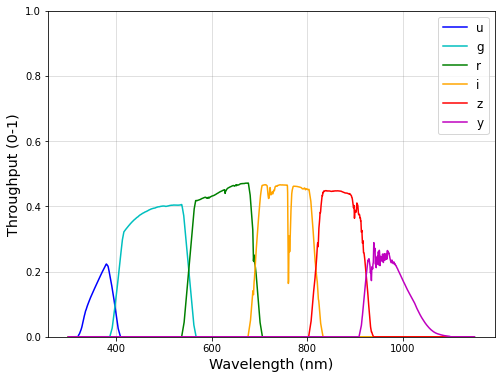

In [5]:
# Plot the curves .. see what we have. 
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}

plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], label=f)
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')

## Read the SED ##

We must also read the kurucz_sun spectrum into a Sed object. Because kurucz_sun contains $\lambda$ / F$_\lambda$, we use the Sed method readSED_flambda. If it had been a file containing $\lambda$ / F$_\nu$, we would use the readSED_fnu method instead.

In [6]:
# Read the SED

sun = Sed()
sun.readSED_flambda('kurucz_sun')

Text(0, 0.5, '$\\lambda F_\\lambda$ (ergs/cm$^2$/s)')

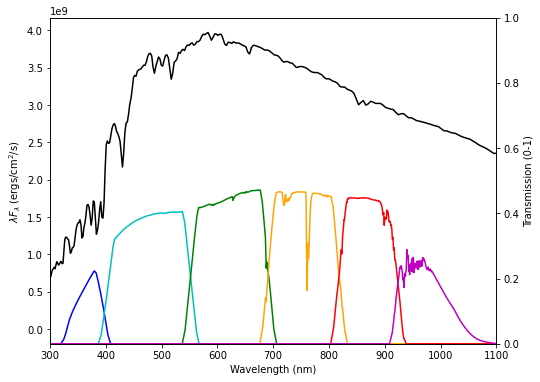

In [7]:
# Let's see what the SED and throughputs look like together
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
for f in filterlist:
    ax2.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f])
ax1.plot(sun.wavelen, sun.wavelen*sun.flambda, color='k')
plt.xlim(300, 1100)
ax1.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Transmission (0-1)')
ax2.set_ylim(0, 1)
ax1.set_ylabel('$\lambda F_\lambda$ (ergs/cm$^2$/s)')

## Calculate the magnitudes ##

Calculating the AB magnitudes. This is simple, using the 'calcMag' method on Sed.

These are the magnitudes 'above the atmosphere' and *as would be reported by Rubin*. Note that these magnitudes *do* include some of the absorption effects of the atmosphere; e.g. the shape of the throughput curves includes the effects of a standard atmosphere. However, the grey-scale extinction due to the atmosphere (or clouds) is not included; this is what is generally meant by 'above the atmosphere' AB magnitudes.

In [8]:
# Calculate expected AB magnitudes. 

mags = {}
for f in filterlist:
    mags[f] = sun.calcMag(lsst[f])

# Make a dataframe just to get a nice output cell.
pd.DataFrame(mags, index=['Sun']).T

,Sun
u,-34.237662
g,-35.407401
r,-35.848487
i,-35.957421
z,-35.969253
y,-35.978175


The sun is pretty bright. 

However, let's suppose we had a star which had a spectrum like the Sun, but was further away. Say we know that it should have an AB magnitude of r=20. 

We can scale the above SED to have the appropriate magnitude in r band, and then calculate the resulting AB magnitudes in the other bandpasses, using the 'calcFluxNorm' and 'multiplyFluxNorm' methods on Sed.

In [9]:
# Scale spectrum and recalculate magnitudes.

r = 20.0

fluxNorm = sun.calcFluxNorm(r, lsst['r'])

sun.multiplyFluxNorm(fluxNorm)

mags = {}
for f in filterlist:
    mags[f] = sun.calcMag(lsst[f])
    
pd.DataFrame(mags, index=['Distant Sun']).T

,Distant Sun
u,21.610825
g,20.441087
r,20.000000
i,19.891067
z,19.879234
y,19.870312


There are other methods on Sed which can be useful - for example, adding dust extinction or redshifting an object. More information is available on these methods in the [class documentation](https://github.com/lsst/rubin_sim/blob/master/rubin_sim/photUtils/Sed.py).